### Customer Sales Analysis - RFM

* Importing the necessary libraries

In [116]:
import warnings
warnings.filterwarnings("ignore")

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as date
import os
from sklearn.mixture import GaussianMixture
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [118]:
data = pd.read_csv('marketing_campaign.csv',sep='\t')

#### Dataset 

People:
1. ID: Customer's unique identifier
2. Year_Birth: Customer's birth year
3. Education: Customer's education level
4. Marital_Status: Customer's marital status
5. Income: Customer's yearly household income
6. Kidhome: Number of children in customer's household
7. Teenhome: Number of teenagers in customer's household
8. Dt_Customer: Date of customer's enrollment with the company
9. Recency: Number of days since customer's last purchase
10. Complain: 1 if the customer complained in the last 2 years, 0 otherwise


Products:

11. MntWines: Amount spent on wine in last 2 years
12. MntFruits: Amount spent on fruits in last 2 years
13. MntMeatProducts: Amount spent on meat in last 2 years
14. MntFishProducts: Amount spent on fish in last 2 years
15. MntSweetProducts: Amount spent on sweets in last 2 years
16. MntGoldProds: Amount spent on gold in last 2 years


Promotion

17. NumDealsPurchases: Number of purchases made with a discount
18. AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
19. AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
20. AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
21. AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
22. AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
23. Response: 1 if customer accepted the offer in the last campaign, 0 otherwise


Place

24. NumWebPurchases: Number of purchases made through the company’s website
25. NumCatalogPurchases: Number of purchases made using a catalogue
26. NumStorePurchases: Number of purchases made directly in stores
27. NumWebVisitsMonth: Number of visits to company’s website in the last month


Target
Need to perform clustering to summarize customer segments.

In [119]:
data.head(3)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0


* Let's look at the data 

In [120]:
data.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,...,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,...,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


In [121]:
data.isna().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [122]:
data.dtypes   

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object

In [123]:
data.duplicated().sum()

0

In [124]:
len(data)

2240

* Data does not have any duplicate values
* Income column has 24 Null values
* Data has 3 object data types and rest all are numeric values

### Data cleaning and Pre-processing

In [125]:
for i in data.columns:
    print("Number of unique values in -{}- are {}".format(i,data[i].nunique()))

Number of unique values in -ID- are 2240
Number of unique values in -Year_Birth- are 59
Number of unique values in -Education- are 5
Number of unique values in -Marital_Status- are 8
Number of unique values in -Income- are 1974
Number of unique values in -Kidhome- are 3
Number of unique values in -Teenhome- are 3
Number of unique values in -Dt_Customer- are 663
Number of unique values in -Recency- are 100
Number of unique values in -MntWines- are 776
Number of unique values in -MntFruits- are 158
Number of unique values in -MntMeatProducts- are 558
Number of unique values in -MntFishProducts- are 182
Number of unique values in -MntSweetProducts- are 177
Number of unique values in -MntGoldProds- are 213
Number of unique values in -NumDealsPurchases- are 15
Number of unique values in -NumWebPurchases- are 15
Number of unique values in -NumCatalogPurchases- are 14
Number of unique values in -NumStorePurchases- are 14
Number of unique values in -NumWebVisitsMonth- are 16
Number of unique v

* Let's work on the object data types first

In [126]:
ob_dtpes = ['Education','Marital_Status','Dt_Customer']


In [127]:
print(data['Education'].unique())
print('\n')
data['Marital_Status'].unique()


['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']




array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

In [128]:
# Converting Eduaction into 2 Catogeries
ed_map = {'Graduation' :'PostGrad', 'PhD':'PostGrad', 'Master':'PostGrad', 'Basic':'UnderGrad', '2n Cycle':'UnderGrad'}
# Converting Marital_status into 2 Catogeries
marital_map = {'Single':'Single', 'Together':'Couple', 'Married':'Couple', 'Divorced':'Single', 'Widow':'Single', 'Alone':'Single',
       'Absurd':'Single', 'YOLO':'Single'}

In [129]:
data['Education'] = data['Education'].map(ed_map)
data['Marital_Status'] = data['Marital_Status'].map(marital_map)

In [130]:
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'])

In [131]:
print("Newest Customer Reg: ",max(data['Dt_Customer']).date())
print("Oldest Customer Reg: ",min(data['Dt_Customer']).date())

Newest Customer Reg:  2014-12-06
Oldest Customer Reg:  2012-01-08


Notes:
* The data that we have is till 2014 - Dec.


Let's do Data manipulation 

### Feature Engineering

* Creating Age by subtracting D.O.B from 2015(data till 2014- Dec).
* Summing all the spendings by the customer

In [132]:
data.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

In [133]:
updated_data = pd.DataFrame()

In [134]:
updated_data['Id'] = data['ID']
updated_data['Age'] = 2015 - data['Year_Birth']
updated_data['Dt_Customer'] = data['Dt_Customer']
updated_data['Recency'] = data['Recency']

updated_data['Kids'] = data['Kidhome']+data['Teenhome']
updated_data['Education'] = data['Education']
updated_data['MaritalStatus'] = data['Marital_Status']
updated_data['Income'] = data['Income']

updated_data["TotalSpendings"] = data['MntWines'] + data['MntFruits'] + data['MntMeatProducts'] +data['MntFishProducts']+data['MntSweetProducts']+data['MntGoldProds']
updated_data["Num_Purchases"] = data['NumCatalogPurchases'] + data['NumDealsPurchases'] + data['NumStorePurchases']+data['NumWebPurchases']
updated_data["Num_WebVisits"] = data['NumWebVisitsMonth']

updated_data["Total_Offer"] =  data["AcceptedCmp1"]+ data["AcceptedCmp2"]+ data["AcceptedCmp3"]+ data["AcceptedCmp4"]+ data["AcceptedCmp5"]


In [135]:
updated_data.head(3)

,Id,Age,Dt_Customer,Recency,Kids,Education,MaritalStatus,Income,TotalSpendings,Num_Purchases,Num_WebVisits,Total_Offer
0,5524,58,2012-04-09,58,0,PostGrad,Single,58138.0,1617,25,7,0
1,2174,61,2014-08-03,38,2,PostGrad,Single,46344.0,27,6,5,0
2,4141,50,2013-08-21,26,0,PostGrad,Couple,71613.0,776,21,4,0


In [136]:
updated_data.isna().sum()

Id                 0
Age                0
Dt_Customer        0
Recency            0
Kids               0
Education          0
MaritalStatus      0
Income            24
TotalSpendings     0
Num_Purchases      0
Num_WebVisits      0
Total_Offer        0
dtype: int64

(array([1.88e+03, 3.28e+02, 7.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 1.00e+00]),
 array([  1730.        ,  75611.77777778, 149493.55555556, 223375.33333333,
        297257.11111111, 371138.88888889, 445020.66666667, 518902.44444444,
        592784.22222222, 666666.        ]),
 <BarContainer object of 9 artists>)

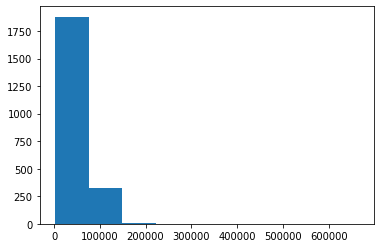

In [137]:
plt.hist(updated_data['Income'],bins=9)

* Let's look at how the data is scattered.

In [138]:
updated_data.head()

,Id,Age,Dt_Customer,Recency,Kids,Education,MaritalStatus,Income,TotalSpendings,Num_Purchases,Num_WebVisits,Total_Offer
0,5524,58,2012-04-09,58,0,PostGrad,Single,58138.0,1617,25,7,0
1,2174,61,2014-08-03,38,2,PostGrad,Single,46344.0,27,6,5,0
2,4141,50,2013-08-21,26,0,PostGrad,Couple,71613.0,776,21,4,0
3,6182,31,2014-10-02,26,1,PostGrad,Couple,26646.0,53,8,6,0
4,5324,34,2014-01-19,94,1,PostGrad,Couple,58293.0,422,19,5,0


### RFM Analysis
* RFM - Recency, Frequency and Monetary, Let's look at these columns for outliers.

In [139]:
import plotly.express as px
import plotly.graph_objects as graph_objects
from plotly.subplots import make_subplots

ax = make_subplots(rows=2,cols=2,subplot_titles=('Recency','TotalSpendings','Num_Purchases','Income'))
ax.add_trace(graph_objects.Box(x=updated_data['Recency'],name='Recency'),row=1,col=1)
ax.add_trace(graph_objects.Box(x=updated_data['Num_Purchases'],name='Frequency'),row=2,col=1)
ax.add_trace(graph_objects.Box(x=updated_data['TotalSpendings'],name='Monetary'),row=1,col=2)
ax.add_trace(graph_objects.Box(x=updated_data['Income'],name='Income'),row=2,col=2)

ax.update_layout(height=400, width=900, title_text='<b>Box Plots to Check Outliers</b>', font_size=12)


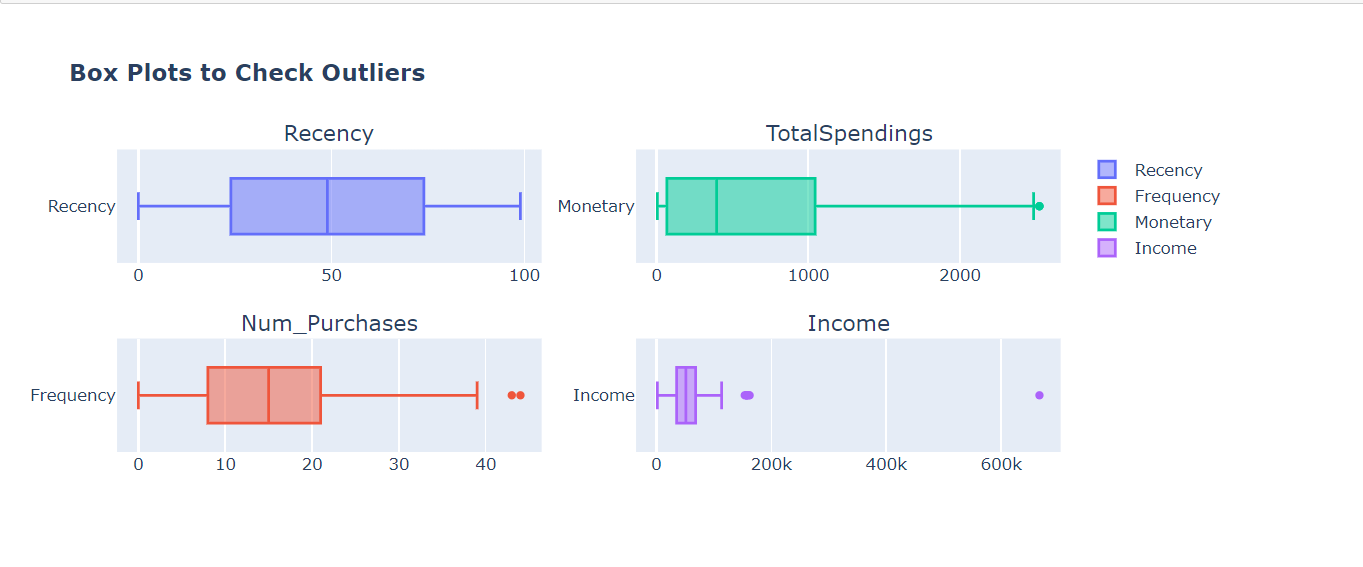

* Income column has few high values that might affect our analysis, similarly let's treat outliers with either maximum or minimum value

**One common way to find outliers in a dataset is to use the interquartile range.**

* The interquartile range, often abbreviated IQR, is the difference between the 25th percentile (Q1) and the 75th percentile (Q3) in a dataset. It measures the spread of the middle 50% of values.

* One popular method is to declare an observation to be an outlier if it has a value 1.5 times greater than the IQR or 1.5 times less than the IQR.

Ref: https://www.statology.org/find-outliers-with-iqr/

#### Treating outliers for the above columns

In [140]:
def treat_outliers(col):
    q1,q3 = updated_data[col].quantile([0.25, 0.75])
    iqr = q3-q1
    lower_limit = q1 - (1.5 * iqr)
    upper_limit = q3 + (1.5 * iqr)
    updated_data.loc[(updated_data[col]<lower_limit),col] = lower_limit
    updated_data.loc[(updated_data[col]>upper_limit),col] = upper_limit
    return None

In [141]:
for i in ['Recency','TotalSpendings','Num_Purchases','Income']:
    treat_outliers(i)

In [142]:
updated_data = updated_data.dropna(subset = ['Income'])

In [143]:
from sklearn.preprocessing import StandardScaler, normalize
scaler=StandardScaler()
X_std=scaler.fit_transform(updated_data[['Income','TotalSpendings']])
X = normalize(X_std,norm='l2')

In [144]:
gmm=GaussianMixture(n_components=6, covariance_type='spherical',max_iter=2000, random_state=42).fit(X)
labels = gmm.predict(X)
updated_data['Cluster'] = labels
updated_data['Cluster']=updated_data['Cluster'].replace({0:'Loyal Customers', 1:'Attention req', 2:'Most Reccent Customers',
       3:'Customers at Risk', 4:'Big Spenders at Risk', 5:'Best Customers'})
# updated_data = data.merge(updated_data.Cluster, left_index=True, right_index=True)

In [149]:
rfm_data = updated_data[['Recency','Num_Purchases','TotalSpendings','Income']]

In [150]:
rfm_data.isna().sum()

Recency           0
Num_Purchases     0
TotalSpendings    0
Income            0
dtype: int64

In [151]:
rfm_data.describe()

,Recency,Num_Purchases,TotalSpendings,Income
count,2216.000000,2216.000000,2216.000000,2216.000000
mean,49.012635,14.878159,607.056352,51874.493231
std,28.948352,7.661360,602.840205,21059.740890
min,0.000000,0.000000,5.000000,1730.000000
25%,24.000000,8.000000,69.000000,35303.000000
50%,49.000000,15.000000,396.500000,51381.500000
75%,74.000000,21.000000,1048.000000,68522.000000
max,99.000000,40.500000,2510.625000,118350.500000


In [152]:
# Imputing mean values of income for the null values
rfm_data['Income'] = rfm_data['Income'].fillna(rfm_data['Income'].mean())

In [153]:
for col in rfm_data.columns:
    rfm_data[col] = rfm_data[col].astype(int)

In [154]:
df = px.data.tips()
fig = px.histogram(rfm_data, x="Income")
fig.show()

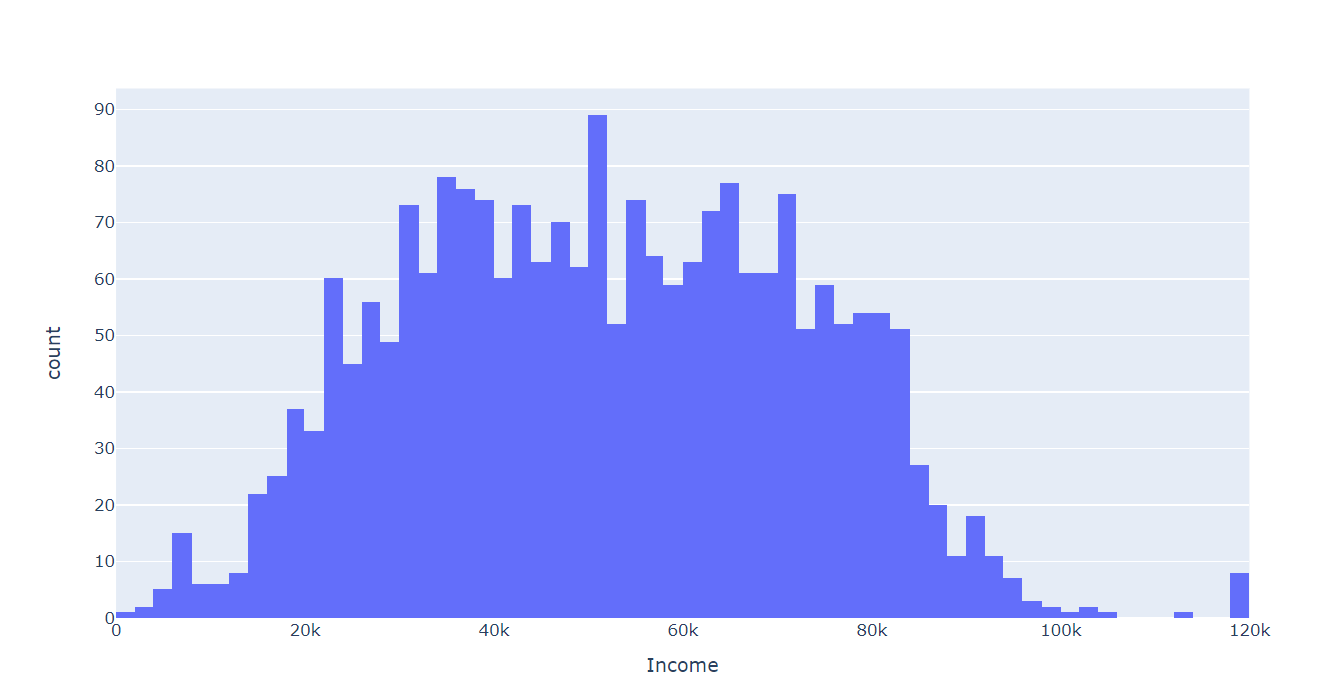

In [155]:
rfm_data.head().style.background_gradient(cmap="GnBu")

,Recency,Num_Purchases,TotalSpendings,Income
0,58,25,1617,58138
1,38,6,27,46344
2,26,21,776,71613
3,26,8,53,26646
4,94,19,422,58293


### Scores


* On scale of 1-3

    * Recency Score
    * Frequency Score - Num_purcahses
    * Monetary Score - Spendings
    
* **RFM Score : Recency*100 + Frequency *10 + Monetary** 
    * Ranges from 111 to 333
    
    
* General rule is that 
    * customer who bought recently is more likely to buy than customer who bought in the past.
    * customer who bought more products is more likely to buy than customer who bought in less.
    * customer who spent more money is more likely to spend than customer who spent less money.

* Reversing the labels as less the number of days more recent the customer can be

In [156]:
rfm_data['Recency'] = pd.qcut(rfm_data['Recency'],3,labels=[3,2,1])

In [157]:
for col in ['Num_Purchases','TotalSpendings']:
    rfm_data[col] = pd.qcut(rfm_data[col],3,labels=[1,2,3])

In [158]:
rfm_data['RFM-Score'] = rfm_data['Recency'].astype(str) + rfm_data['Num_Purchases'].astype(str) + rfm_data['TotalSpendings'].astype(str)

In [159]:
rfm_data.head(3)

,Recency,Num_Purchases,TotalSpendings,Income,RFM-Score
0,2,3,3,58138,233
1,2,1,1,46344,211
2,3,3,2,71613,332


### Segmenting Customers Based on their RFM Scores

**Segmentations**

   * Best Customers - Customers with score -333
   * Loyal Customers - Customers who buys frequently - X3X
   * Recent Customers - Customers who bought recently - 3XX 
   * Spenders at Risk - Who spent good amount of money but have not returned recently - 1X3
   * Big spenders - Customers who spend more money - 2X3,3X3
   * Customers at Risk - 111
    

In [160]:
seg_map = {
    r'333': 'Best Customers',
    r'[1-3]3[1-3]': 'Loyal Customers',
    r'3[1-3][1-3]': 'Most Reccent Customers',
    r'1[1-3]3': 'Big Spenders at Risk',
    r'[2-3][1-3]3': 'Big Spenders',
    r'111': 'Customers at Risk',
    r'[1-2][1-2][1-2]' : 'Attention req'
}
rfm_data['customer_segment'] = rfm_data['RFM-Score'].replace(seg_map, regex=True)


In [161]:
rfm_data.head(3)

,Recency,Num_Purchases,TotalSpendings,Income,RFM-Score,customer_segment
0,2,3,3,58138,233,Loyal Customers
1,2,1,1,46344,211,Attention req
2,3,3,2,71613,332,Loyal Customers


In [162]:
rfm_data['customer_segment'].unique()

array(['Loyal Customers', 'Attention req', 'Most Reccent Customers',
       'Customers at Risk', 'Big Spenders at Risk', 'Best Customers',
       'Big Spenders'], dtype=object)

In [167]:
plot_data = updated_data[['Income','Num_Purchases','TotalSpendings']]
plot_data['customer_segment'] = rfm_data['customer_segment']

In [169]:
PLOT = graph_objects.Figure()
for C in list(plot_data.customer_segment.unique()):
    

    PLOT.add_trace(graph_objects.Scatter3d(x = plot_data[plot_data.customer_segment == C]['Income'],
                                y = plot_data[plot_data.customer_segment == C]['Num_Purchases'],
                                z = plot_data[plot_data.customer_segment == C]['TotalSpendings'],                        
                                mode = 'markers',marker_size = 6, marker_line_width = 1,
                                name = str(C)))
PLOT.update_traces(hovertemplate='Income: %{x} <br>Frequency(Purchses): %{y} <br>Spending: %{z}')

    
PLOT.update_layout(width = 800, height = 600, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'Income', titlefont_color = 'black'),
                                yaxis=dict(title = 'Purchases', titlefont_color = 'black'),
                                zaxis=dict(title = 'Spending', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))

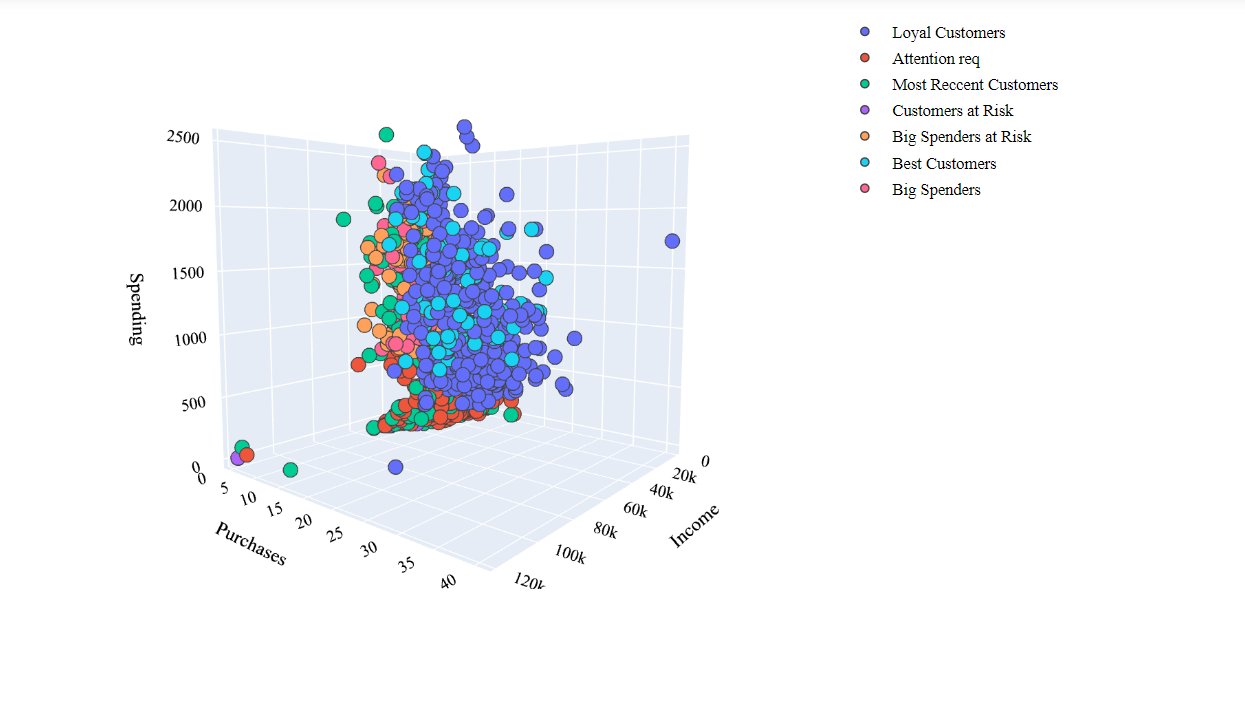

In [41]:
groups = rfm_data.groupby("customer_segment").groups
keys,values= [],[]
for i in groups.keys():
    keys.append(i)
    values.append(len(groups[i]))

In [42]:
df = pd.DataFrame()

In [43]:
df['Segments'] = keys
df['Number of Customers'] = values

In [44]:
df.head(3)

,Segments,Number of Customers
0,Attention req,610
1,Best Customers,157
2,Big Spenders,77


In [45]:
fig = px.pie(df, values='Number of Customers', names='Segments', title='Customer Segmentation')
fig.show()

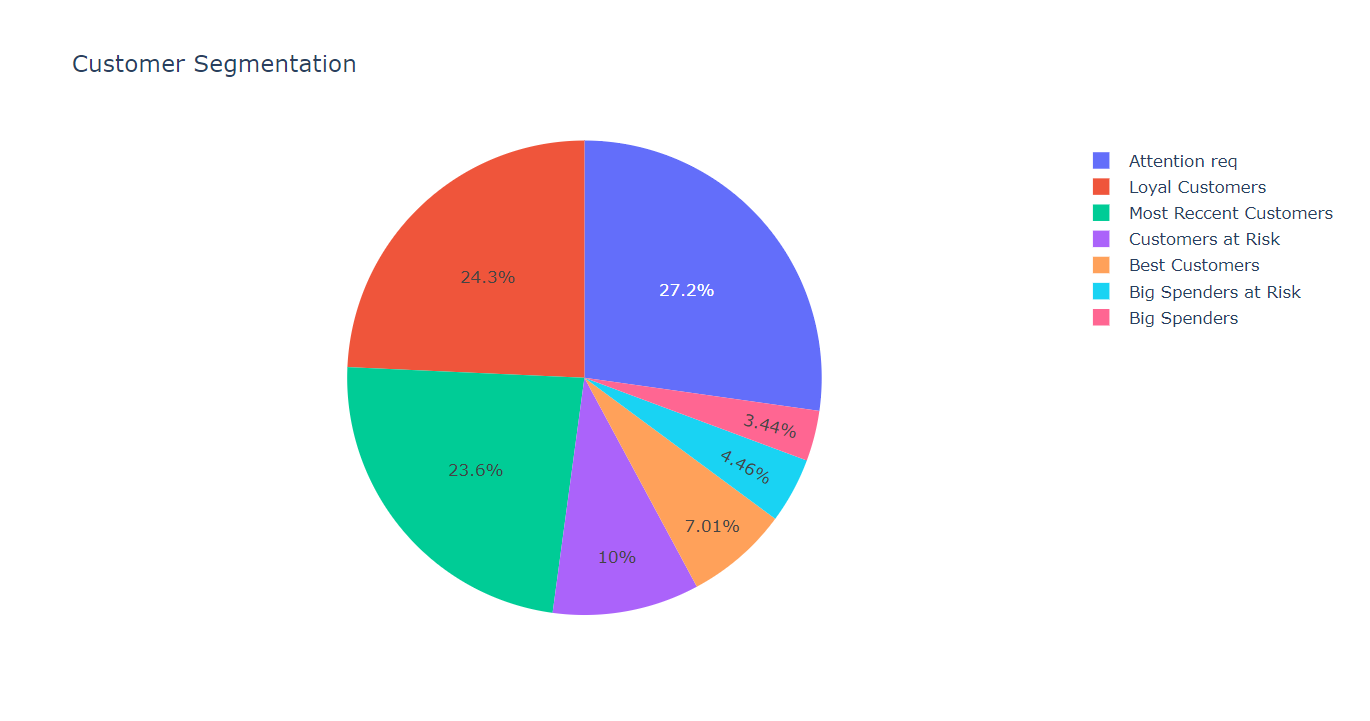